In [ ]:
!pip install causalml
!pip install shap
!pip install Lightgbm

# importing manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import _tree

# importing preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
# importing model libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# importing evaluation libraries
from sklearn.metrics import mean_squared_error, r2_score





In [3]:
df=pd.read_csv('Life Expectancy Data.csv')

In [4]:
# splitting the data into train and test sets
# Although this step is not needed, I had done this for the regression model I built with the same dataset
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [5]:
# splitting the data into train and test sets
train_set, test_set = shuffle_and_split_data(df, 0.2)
len(train_set)

2351

In [6]:
len(test_set)

587

In [7]:
# dropping the country and year columns
train_set=train_set.drop(['Country','Year'],axis=1)
test_set=test_set.drop(['Country','Year'],axis=1)

In [8]:
df.shape

(2938, 22)

In [9]:
df.sample(20)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2505,Sweden,2015,Developed,82.4,53.0,0,NaN,0.000000,67.0,22,...,98.0,NaN,98.0,0.1,5585.258470,9799186.0,1.5,1.4,0.909,15.9
1966,Panama,2008,Developing,76.5,127.0,1,6.74,956.822976,86.0,0,...,86.0,6.75,86.0,0.1,6973.928400,3516268.0,2.0,2.0,0.750,12.8
2277,Serbia,2003,Developing,73.0,134.0,1,7.25,389.751521,NaN,15,...,89.0,8.13,89.0,0.1,2832.496520,748591.0,2.7,2.7,0.715,13.0
667,Cuba,2005,Developing,77.2,19.0,1,4.48,518.935922,95.0,0,...,99.0,9.39,89.0,0.1,3779.577000,NaN,3.4,3.3,0.719,14.2
2780,United Republic of Tanzania,2013,Developing,59.7,323.0,86,4.20,0.000000,91.0,185,...,91.0,5.57,91.0,2.1,NaN,NaN,6.8,6.7,NaN,NaN
312,Bolivia (Plurinational State of),2007,Developing,66.8,216.0,11,3.47,0.000000,84.0,0,...,85.0,4.96,84.0,0.2,NaN,NaN,1.3,1.2,0.626,14.1
2809,United States of America,2000,Developed,76.8,114.0,28,8.21,0.000000,9.0,85,...,9.0,13.70,94.0,0.1,NaN,NaN,0.8,0.7,NaN,NaN
1036,Greece,2005,Developing,79.3,81.0,0,9.95,2785.139364,93.0,122,...,96.0,9.36,96.0,0.1,22551.735740,1987314.0,0.8,0.7,0.839,15.6
2385,Somalia,2007,Developing,51.5,34.0,52,0.01,0.000000,NaN,1149,...,4.0,NaN,4.0,0.9,NaN,NaN,7.3,7.1,NaN,NaN
701,Czechia,2003,Developed,75.2,122.0,0,13.01,0.000000,92.0,30,...,97.0,7.13,97.0,0.1,NaN,NaN,2.2,2.2,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [11]:
# summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
Life expectancy,2928.0,6.922493e+01,9.523867e+00,36.30000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01
Adult Mortality,2928.0,1.647964e+02,1.242921e+02,1.00000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02
infant deaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.01000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
percentage expenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04
Hepatitis B,2385.0,8.094046e+01,2.507002e+01,1.00000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,2938.0,2.419592e+03,1.146727e+04,0.00000,0.000000,1.700000e+01,3.602500e+02,2.121830e+05
BMI,2904.0,3.832125e+01,2.004403e+01,1.00000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
under-five deaths,2938.0,4.203574e+01,1.604455e+02,0.00000,0.000000,4.000000e+00,2.800000e+01,2.500000e+03


In [12]:
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

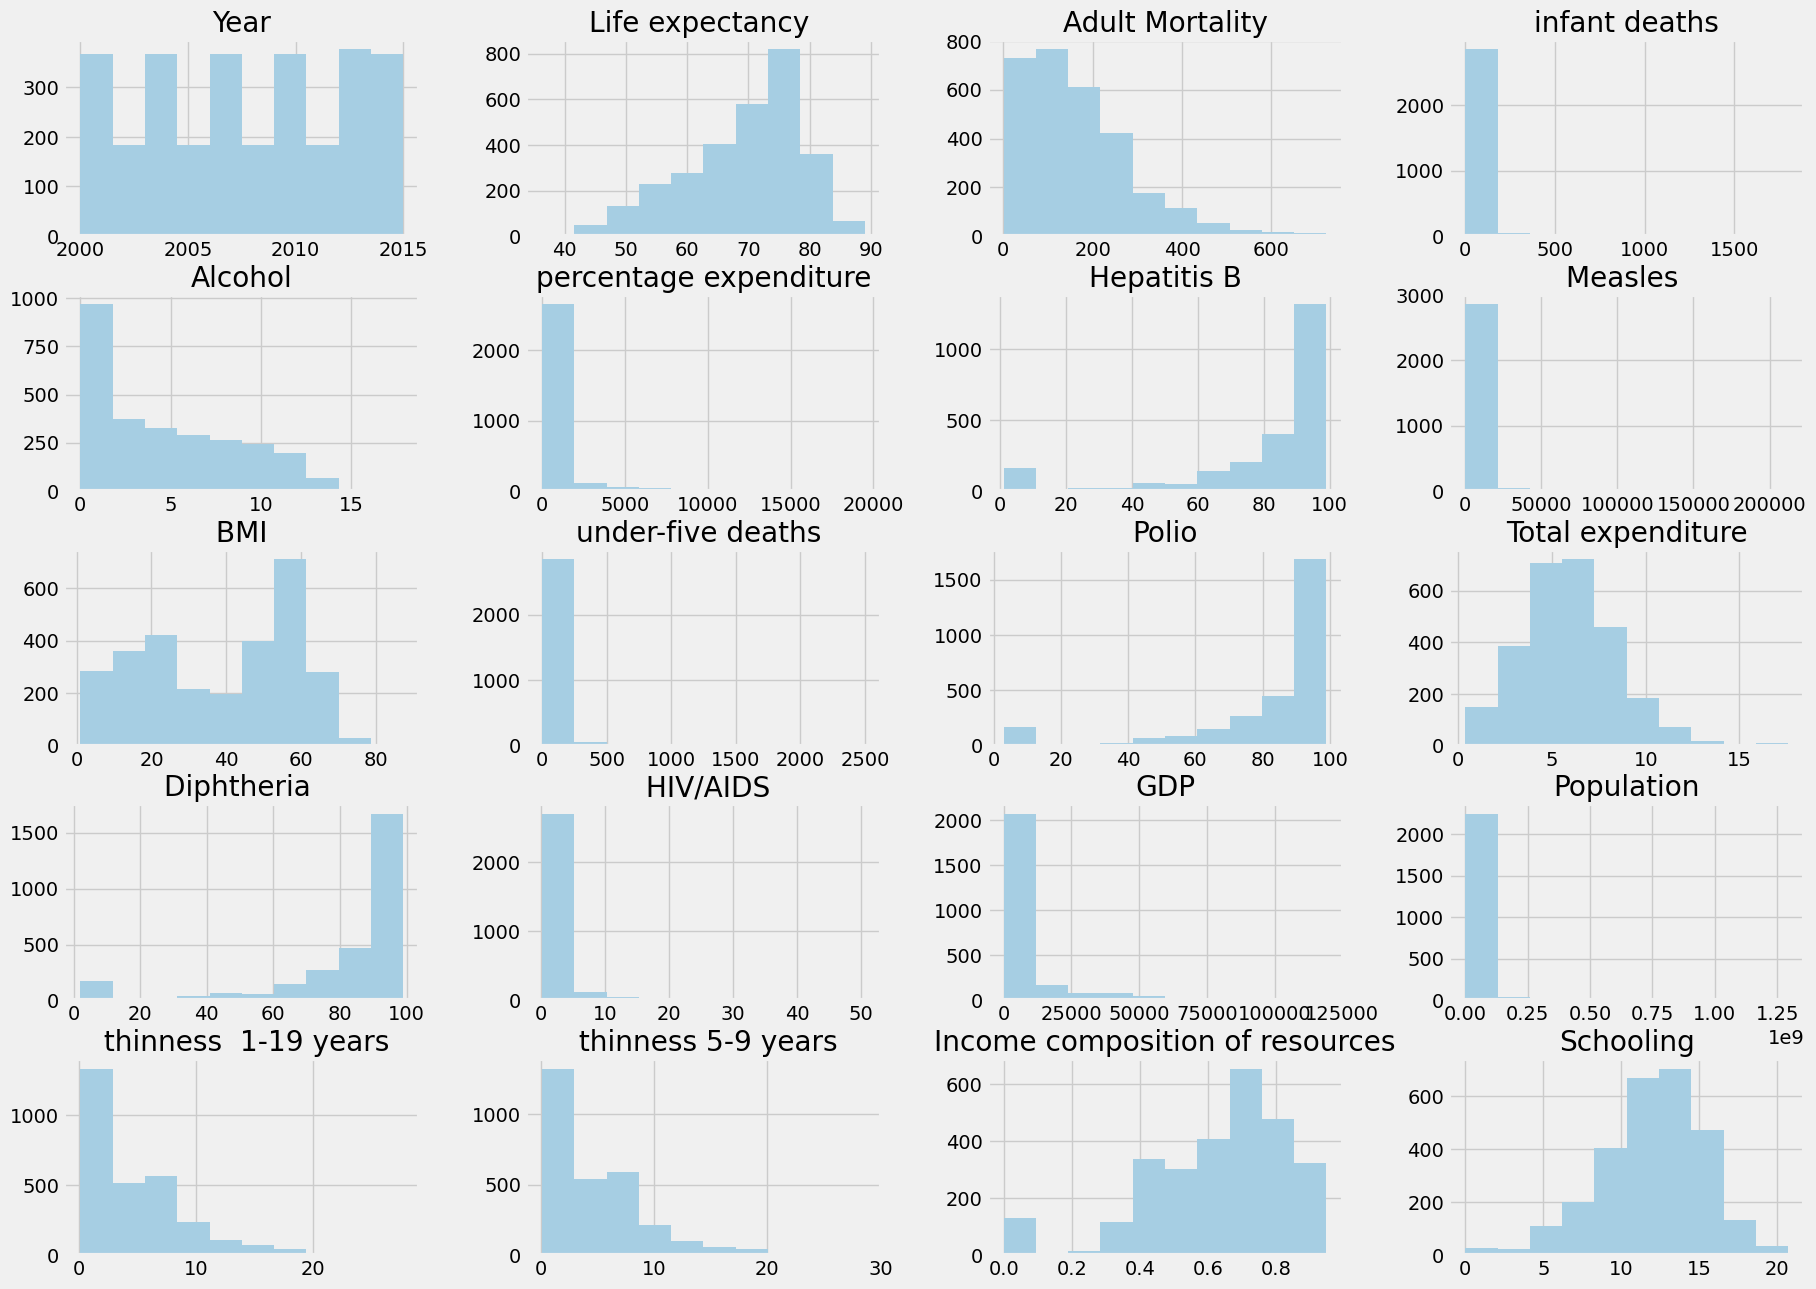

In [13]:
# univariate analysis: plotting the distribution of the all the columns
df.hist(figsize=(20,15));

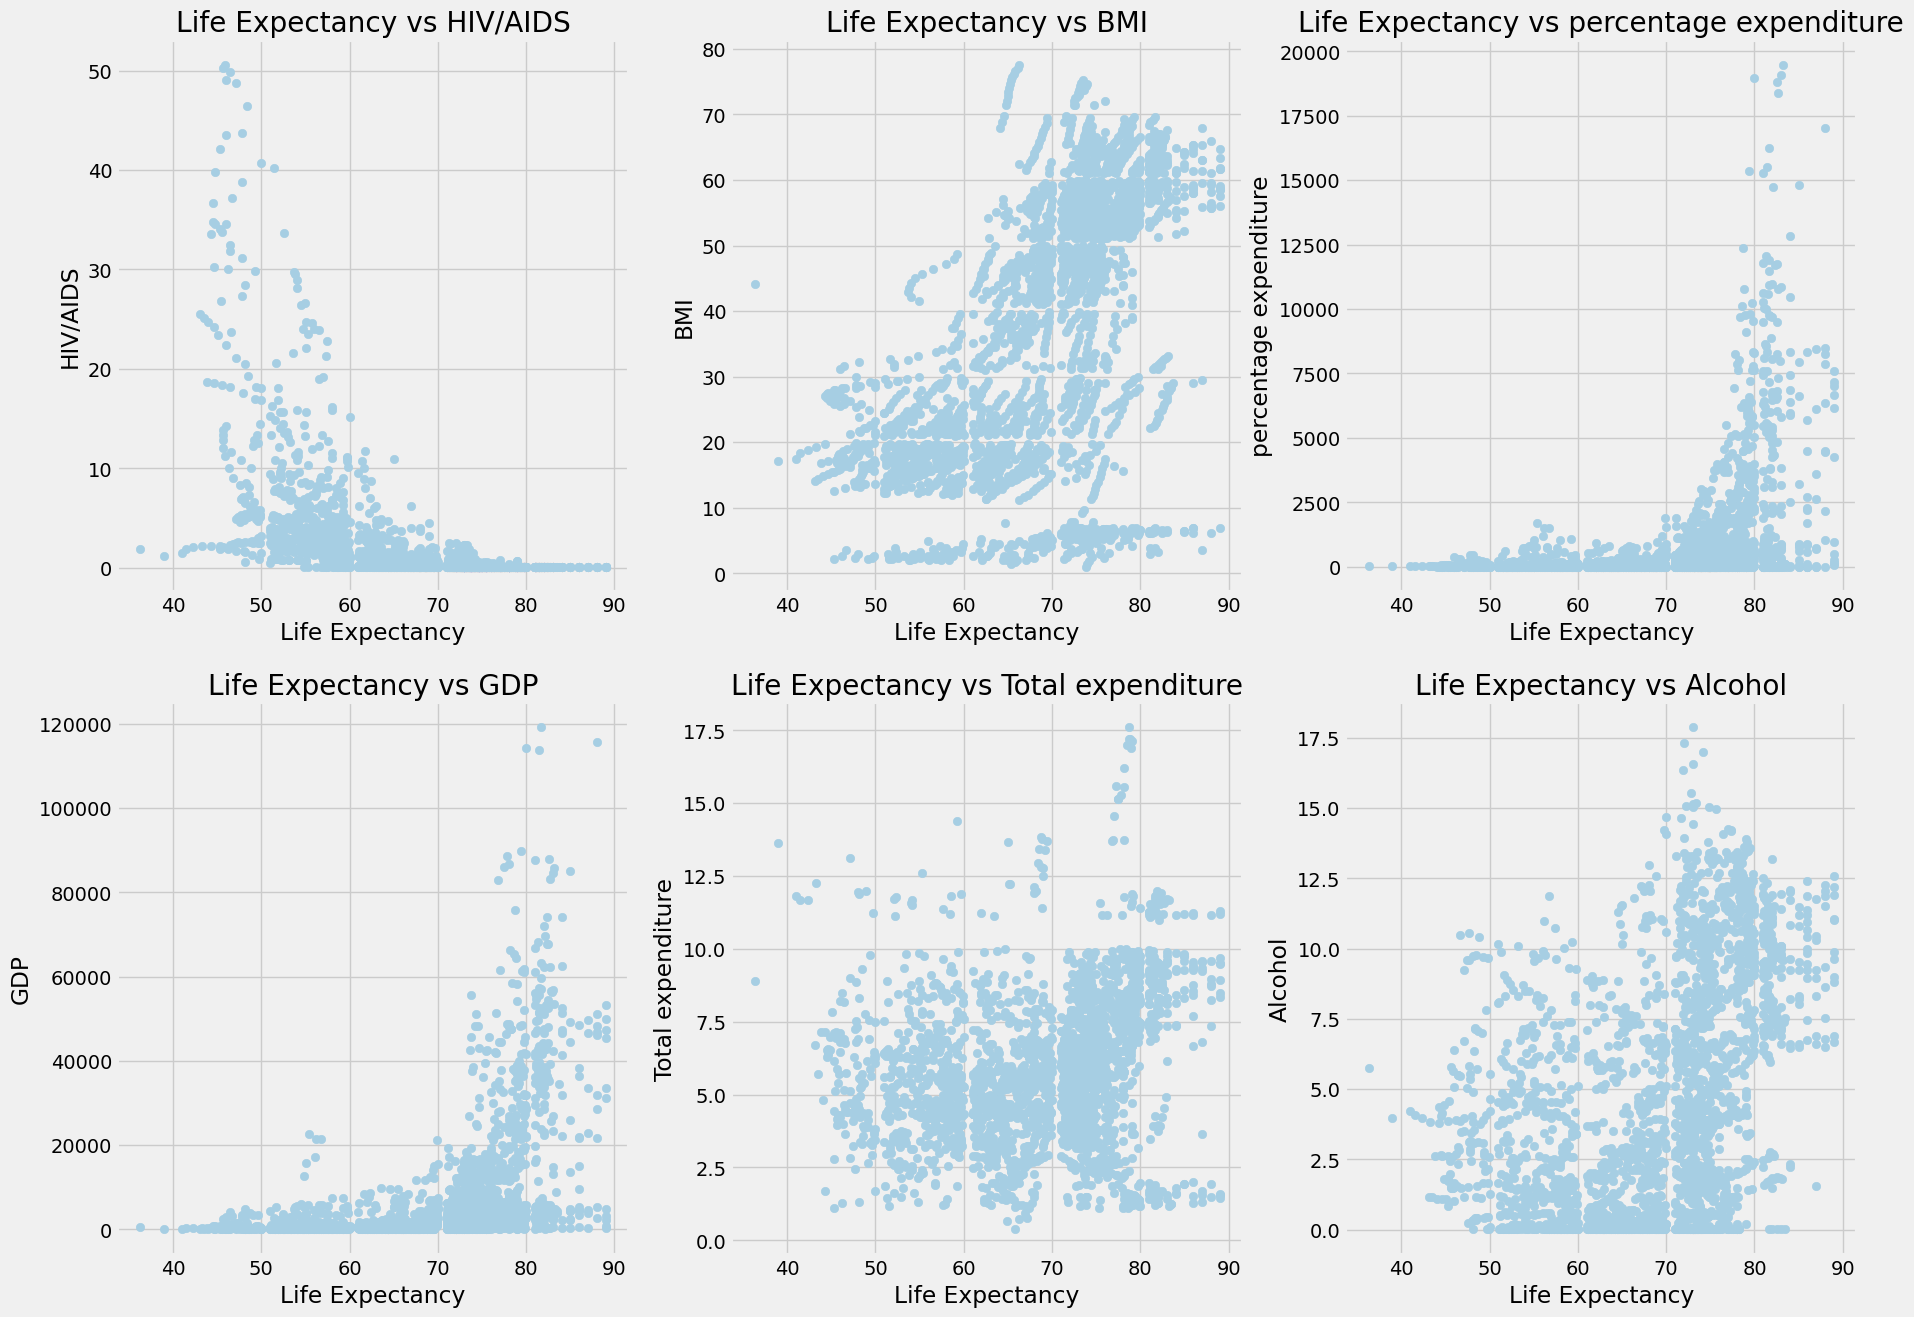

In [14]:
# bivariate analysis: plotting the distribution of notable features against the target variable
plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
plt.scatter(df['Life expectancy '],df[' HIV/AIDS'])
plt.xlabel('Life Expectancy')
plt.ylabel('HIV/AIDS')
plt.title('Life Expectancy vs HIV/AIDS');

plt.subplot(2,3,2)
plt.scatter(df['Life expectancy '],df[' BMI '])
plt.xlabel('Life Expectancy')
plt.ylabel('BMI')
plt.title('Life Expectancy vs BMI');

plt.subplot(2,3,3)
plt.scatter(df['Life expectancy '],df['percentage expenditure'])
plt.xlabel('Life Expectancy')
plt.ylabel('percentage expenditure')
plt.title('Life Expectancy vs percentage expenditure');

plt.subplot(2,3,4)
plt.scatter(df['Life expectancy '],df['GDP'])
plt.xlabel('Life Expectancy')
plt.ylabel('GDP')
plt.title('Life Expectancy vs GDP');

plt.subplot(2,3,5)
plt.scatter(df['Life expectancy '],df['Total expenditure'])
plt.xlabel('Life Expectancy')
plt.ylabel('Total expenditure')
plt.title('Life Expectancy vs Total expenditure');

plt.subplot(2,3,6)
plt.scatter(df['Life expectancy '],df['Alcohol'])
plt.xlabel('Life Expectancy')
plt.ylabel('Alcohol')
plt.title('Life Expectancy vs Alcohol');


In [15]:
# checking the average life expectancy of the countries grouped by status
mean_life_expectancy = df.groupby('Status')['Life expectancy '].mean()
mean_life_expectancy


Status
Developed     79.197852
Developing    67.111465
Name: Life expectancy , dtype: float64

Text(0, 0.5, 'Life Expectancy')

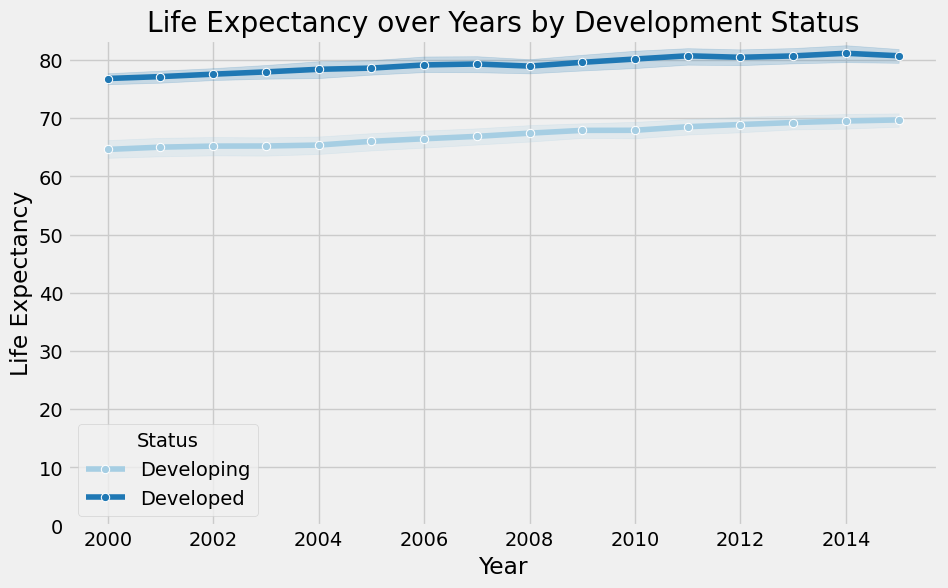

In [16]:
# Checking the temporal trend of life expectancy grouped by status
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Life expectancy ', hue='Status', marker='o').set_ylim(bottom=0)

plt.title('Life Expectancy over Years by Development Status')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')



In [17]:
# Checking the correlation between the features
df.select_dtypes(exclude='object').corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.170033,-0.079052,-0.037415,-0.052990,0.031400,0.104333,-0.082493,0.108974,-0.042937,0.094158,0.090740,0.134337,-0.139741,0.101620,0.016969,-0.047876,-0.050929,0.243468,0.209400
Life expectancy,0.170033,1.000000,-0.696359,-0.196557,0.404877,0.381864,0.256762,-0.157586,0.567694,-0.222529,0.465556,0.218086,0.479495,-0.556556,0.461455,-0.021538,-0.477183,-0.471584,0.724776,0.751975
Adult Mortality,-0.079052,-0.696359,1.000000,0.078756,-0.195848,-0.242860,-0.162476,0.031176,-0.387017,0.094146,-0.274823,-0.115281,-0.275131,0.523821,-0.296049,-0.013647,0.302904,0.308457,-0.457626,-0.454612
infant deaths,-0.037415,-0.196557,0.078756,1.000000,-0.115638,-0.085612,-0.223566,0.501128,-0.227279,0.996629,-0.170689,-0.128616,-0.175171,0.025231,-0.108427,0.556801,0.465711,0.471350,-0.145139,-0.193720
Alcohol,-0.052990,0.404877,-0.195848,-0.115638,1.000000,0.341285,0.087549,-0.051827,0.330408,-0.112370,0.221734,0.296942,0.222020,-0.048845,0.354712,-0.035252,-0.428795,-0.417414,0.450040,0.547378
percentage expenditure,0.031400,0.381864,-0.242860,-0.085612,0.341285,1.000000,0.016274,-0.056596,0.228700,-0.087852,0.147259,0.174420,0.143624,-0.097857,0.899373,-0.025662,-0.251369,-0.252905,0.381952,0.389687
Hepatitis B,0.104333,0.256762,-0.162476,-0.223566,0.087549,0.016274,1.000000,-0.120529,0.150380,-0.233126,0.486171,0.058280,0.611495,-0.112675,0.083903,-0.123321,-0.120429,-0.124960,0.199549,0.231117
Measles,-0.082493,-0.157586,0.031176,0.501128,-0.051827,-0.056596,-0.120529,1.000000,-0.175977,0.507809,-0.136166,-0.106241,-0.141882,0.030899,-0.076466,0.265966,0.224808,0.221072,-0.129568,-0.137225
BMI,0.108974,0.567694,-0.387017,-0.227279,0.330408,0.228700,0.150380,-0.175977,1.000000,-0.237669,0.284569,0.242503,0.283147,-0.243717,0.301557,-0.072301,-0.532025,-0.538911,0.508774,0.546961
under-five deaths,-0.042937,-0.222529,0.094146,0.996629,-0.112370,-0.087852,-0.233126,0.507809,-0.237669,1.000000,-0.188720,-0.130148,-0.195668,0.038062,-0.112081,0.544423,0.467789,0.472263,-0.163305,-0.209373


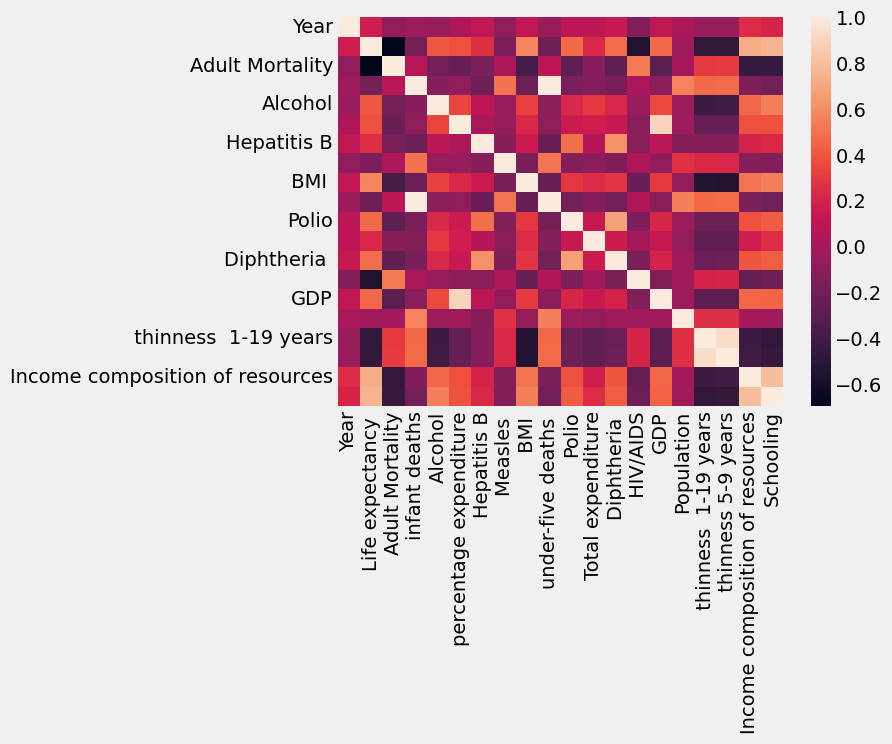

In [18]:
# plotting the correlation matrix
sns.heatmap(df.select_dtypes(exclude=['object']).corr());


In [19]:
# encoding the categorical variables
cols_to_dummy=train_set.select_dtypes(include='object').columns
train_set_dummy=pd.get_dummies(train_set,columns=cols_to_dummy,drop_first=True,dtype='int')
train_set_dummy.shape

test_set_dummy=pd.get_dummies(test_set,columns=cols_to_dummy,drop_first=True,dtype='int')

In [20]:
# instantiating the imputer
imputer = KNNImputer(n_neighbors=15, metric='nan_euclidean')


In [21]:
# imputing the missing values using the KNN imputer
imputed_data = imputer.fit_transform(train_set_dummy.select_dtypes(exclude='object'))
imputed_data=pd.DataFrame(imputed_data,columns=train_set_dummy.columns)
imputed_data.isna().sum()


imputed_data_test = imputer.fit_transform(test_set_dummy.select_dtypes(exclude='object'))
imputed_data_test=pd.DataFrame(imputed_data_test,columns=test_set_dummy.columns)
imputed_data_test.isna().sum()



Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Status_Developing                  0
dtype: int64

In [22]:


imputed_data.shape

(2351, 20)

In [23]:
imputed_data.columns

Index(['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')

In [24]:
imputed_data.isna().sum()

Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Status_Developing                  0
dtype: int64

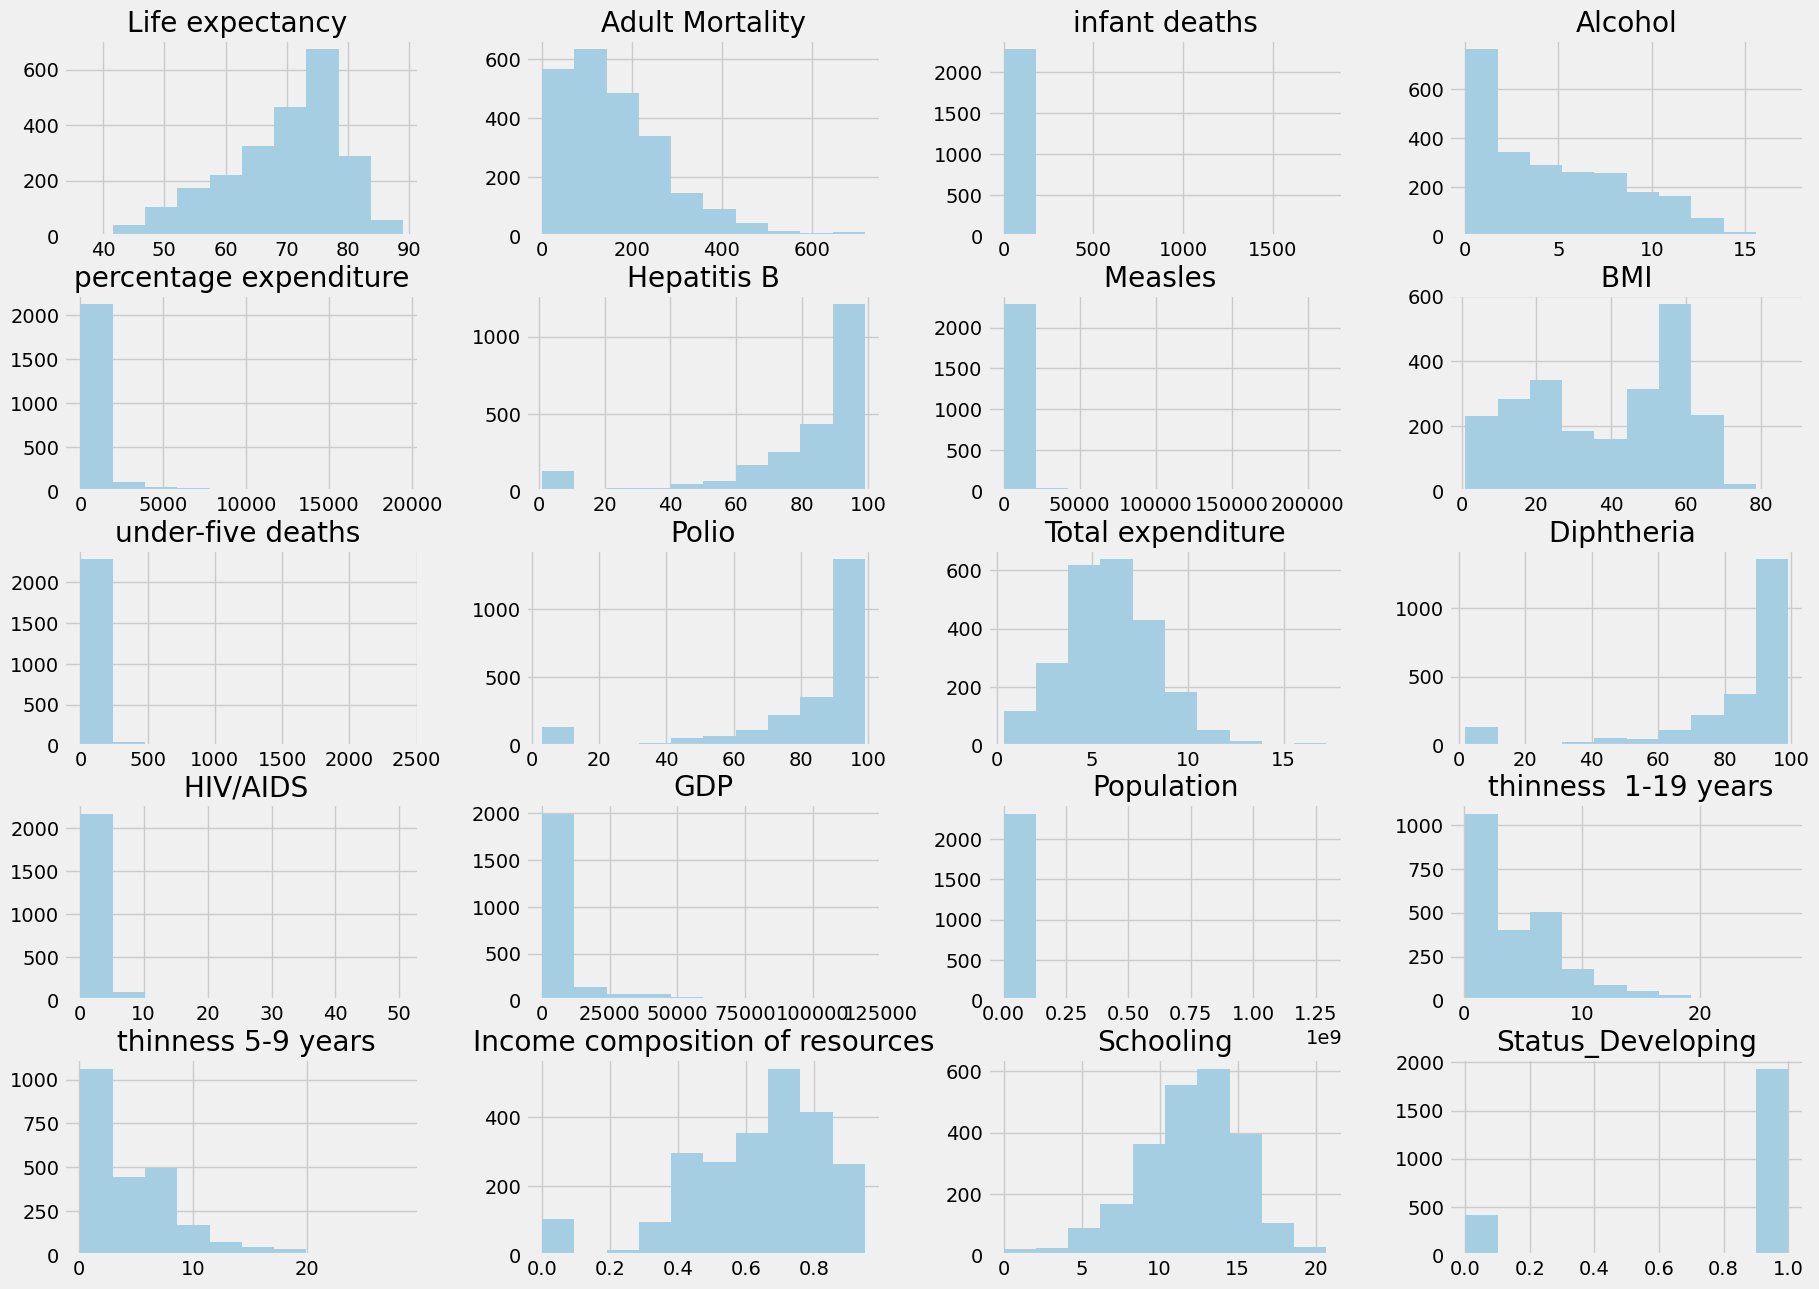

In [25]:
# comparing the distributions of the original and imputed data
imputed_data.hist(figsize=(20,15));

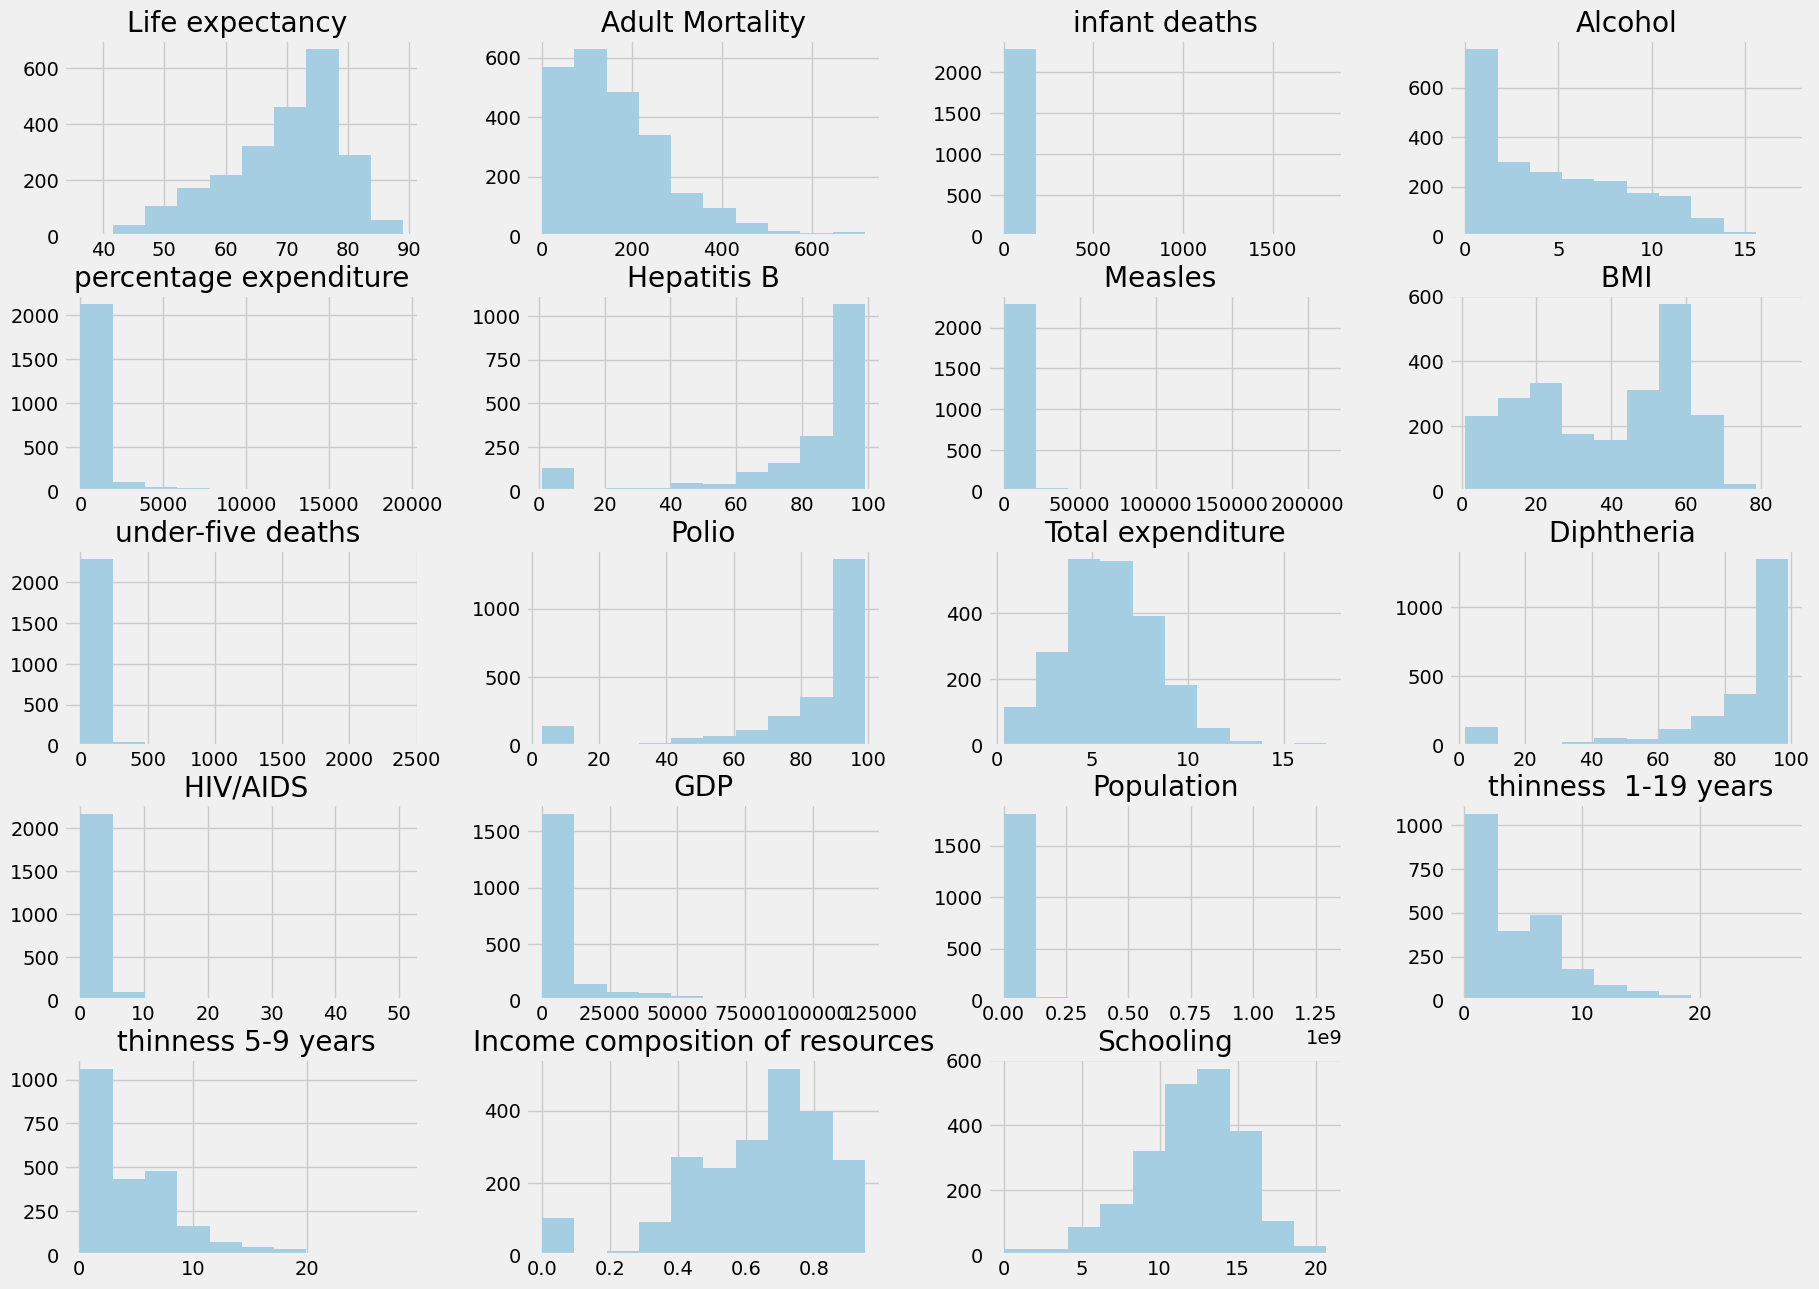

In [26]:
train_set.hist(figsize=(20,15));

In [27]:
# checking fr outliers using the isolation forest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(imputed_data)
outlier_pred


array([1, 1, 1, ..., 1, 1, 1])

In [28]:
# Removing the outlierrs.
print("Number of rows without outliers:", len(imputed_data[outlier_pred == 1]))
imputed_data = imputed_data.iloc[outlier_pred == 1]

print("New shape:", imputed_data.shape)
imputed_data.shape


Number of rows without outliers: 2189
New shape: (2189, 20)


(2189, 20)

## Causal Machine Learning

In [65]:
imputed_data.head()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
0,67.8,235.0,7.0,6.64,808.243302,99.000000,0.0,48.5,8.0,99.0,4.13,98.0,0.1,7165.277500,1.692710e+05,2.3,2.5,0.758,14.6,1.0
1,79.0,93.0,1.0,4.37,13.669102,97.000000,0.0,6.7,1.0,99.0,11.60,99.0,0.1,75.519900,5.429573e+06,3.4,3.3,0.772,14.0,1.0
2,75.3,122.0,1.0,9.16,880.640337,91.000000,1.0,58.9,1.0,97.0,1.12,95.0,0.1,6353.826383,7.164132e+06,2.1,2.1,0.766,14.1,1.0
3,74.1,137.0,12.0,7.68,1349.025282,93.466667,6.0,54.0,14.0,88.0,9.21,83.0,0.1,7669.273916,3.757452e+06,1.2,1.1,0.764,15.0,1.0
4,65.6,215.0,6.0,2.35,37.884661,97.000000,0.0,43.4,8.0,97.0,1.88,96.0,0.1,436.459223,5.795000e+03,3.2,3.3,0.000,10.5,1.0


In [66]:
imputed_data.shape

(2776, 20)

In [67]:
# Appeding the test_set and the train_set 
imputed_data = pd.concat([imputed_data, imputed_data_test])
imputed_data.shape

(3363, 20)

In [83]:
imputed_data.columns

Index(['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')

In [84]:
# choosing the treament, features and the target variable
X= imputed_data[[ 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'
       ]]
treatment= imputed_data['Status_Developing']
y= imputed_data['Life expectancy ']


In [85]:
# Estimating the ATE using the LRSRegressor
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (Linear Regression): -1.55 (-1.99, -1.12)


In [86]:
# Estimating the ATE using the XGBTRegressor
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): -6.90 (-7.19, -6.60)


In [87]:
# Instantiating the model to be used for feature importance
model_tau = LGBMRegressor(importance_type='gain')

In [88]:
# Getting the feature importance
w_multi = np.array(['treatment' if x == 1 else 'control' for x in treatment])
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = RandomForestRegressor()
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=X.columns)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3597
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 19
[LightGBM] [Info] Start training from score 69.409624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3597
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 19
[LightGBM] [Info] Start training from score 69.409624


{'treatment': Income composition of resources    0.471047
  HIV/AIDS                          0.229653
 Adult Mortality                    0.214604
 Schooling                          0.027721
 percentage expenditure             0.016716
 Diphtheria                         0.009121
  BMI                               0.008821
 Polio                              0.003500
  thinness 5-9 years                0.003055
 Total expenditure                  0.002886
 Measles                            0.002402
 Population                         0.002210
 Alcohol                            0.002071
 Hepatitis B                        0.001895
  thinness  1-19 years              0.001576
 GDP                                0.001489
 under-five deaths                  0.000701
 infant deaths                      0.000532
 dtype: float64}

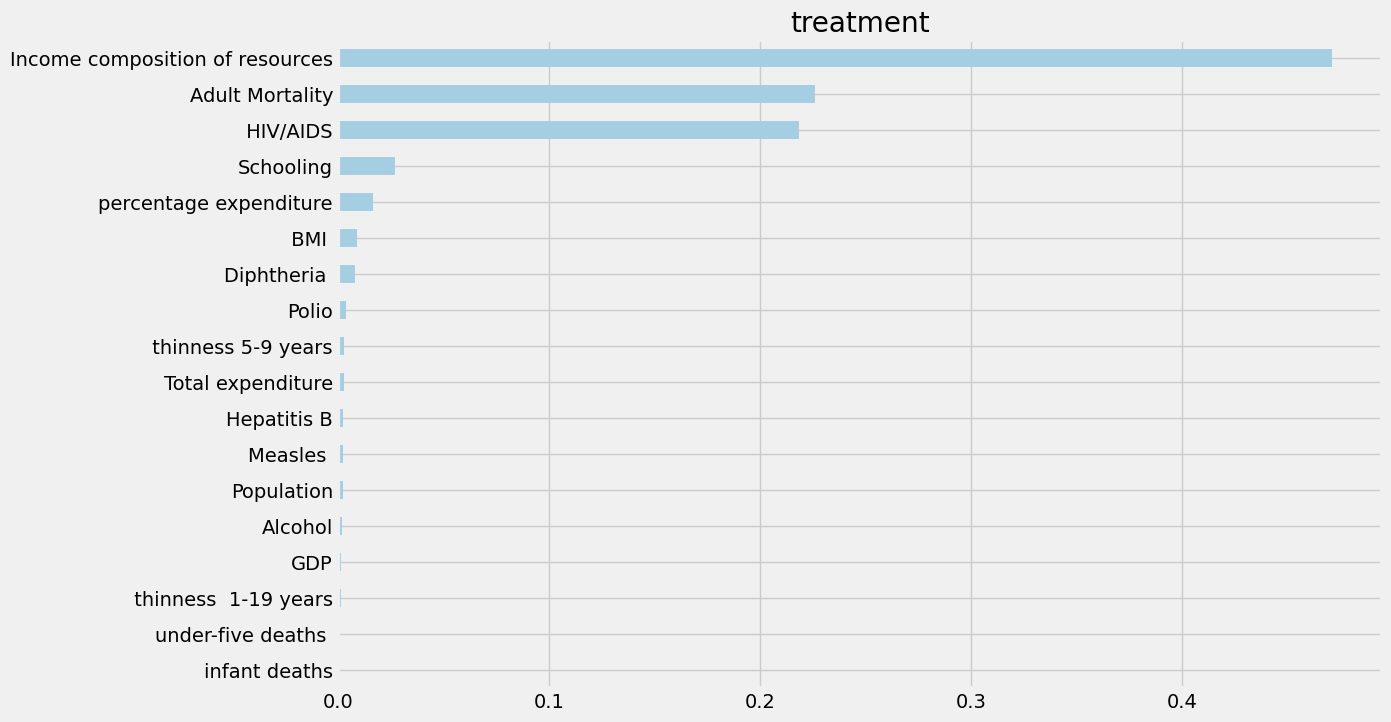

In [89]:
# plotting the feature importance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True,model_tau_feature=model_tau_feature, method='auto',features=X.columns)


In [90]:
# permutation importance on test set
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, X.columns).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Converting column-vector to 1d array


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3511
[LightGBM] [Info] Number of data points in the train set: 2354, number of used features: 18
[LightGBM] [Info] Start training from score -0.288002
Elapsed time: 1.341521978378296 seconds


In [91]:
# printing the permutation importance
pd.Series(perm_imp_test, X.columns).sort_values(ascending=False)


Income composition of resources    1.551549
Adult Mortality                    0.437101
 HIV/AIDS                          0.361606
Schooling                          0.095129
percentage expenditure             0.039965
 BMI                               0.015027
Diphtheria                         0.013838
Measles                            0.005902
Total expenditure                  0.005415
Polio                              0.004696
 thinness 5-9 years                0.003632
Population                         0.003078
GDP                                0.002480
Alcohol                            0.002378
Hepatitis B                        0.000797
 thinness  1-19 years              0.000474
infant deaths                      0.000249
under-five deaths                  0.000165
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

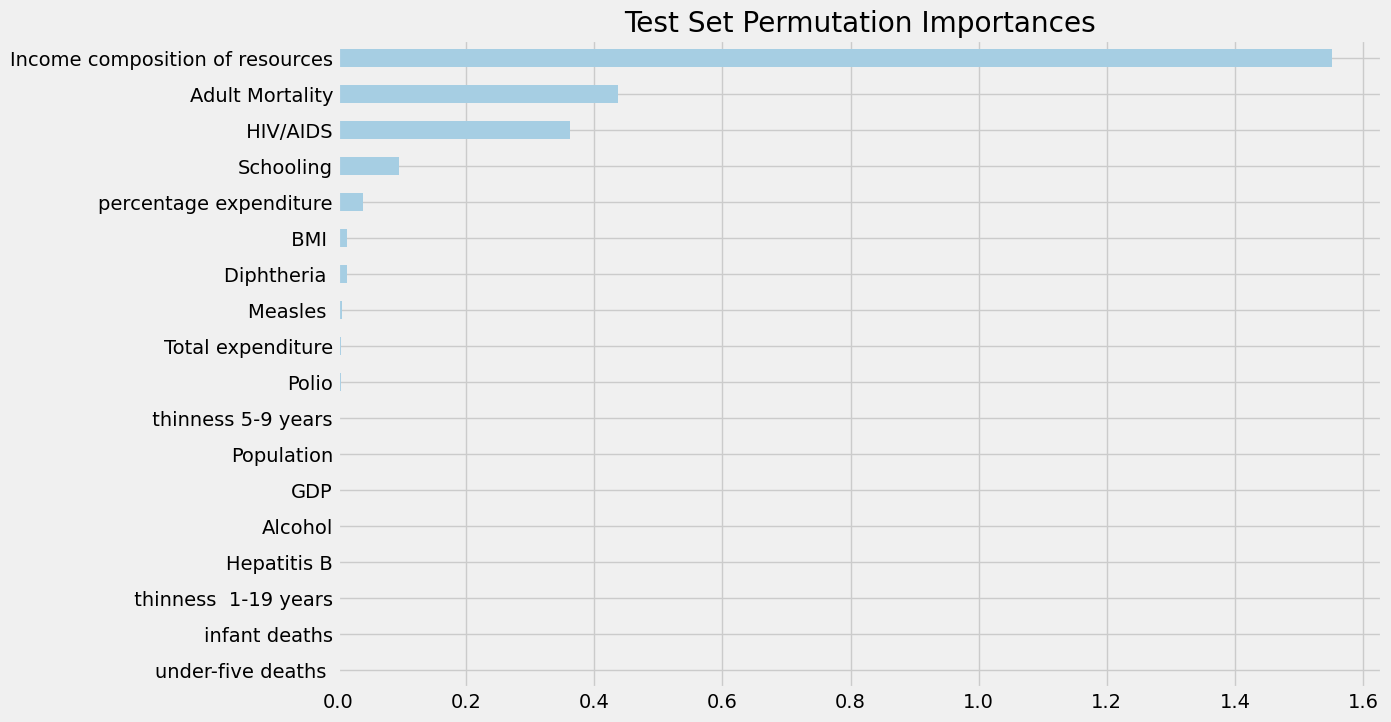

In [92]:
# plotting the permutation importance
pd.Series(perm_imp_test, X.columns).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [93]:
# permutation importance on train set
perm_imp_train = permutation_importance(
    estimator=model_tau_fit,
    X=X_train,
    y=y_train,
    random_state=42).importances_mean
pd.Series(perm_imp_train, X.columns).sort_values(ascending=False)

Income composition of resources    1.541729
Adult Mortality                    0.450133
 HIV/AIDS                          0.323955
Schooling                          0.097317
percentage expenditure             0.049877
Diphtheria                         0.015878
 BMI                               0.015076
Measles                            0.005161
Polio                              0.005108
Total expenditure                  0.004217
 thinness 5-9 years                0.004167
Population                         0.003437
Alcohol                            0.003147
GDP                                0.002237
Hepatitis B                        0.001184
 thinness  1-19 years              0.000918
infant deaths                      0.000318
under-five deaths                  0.000177
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

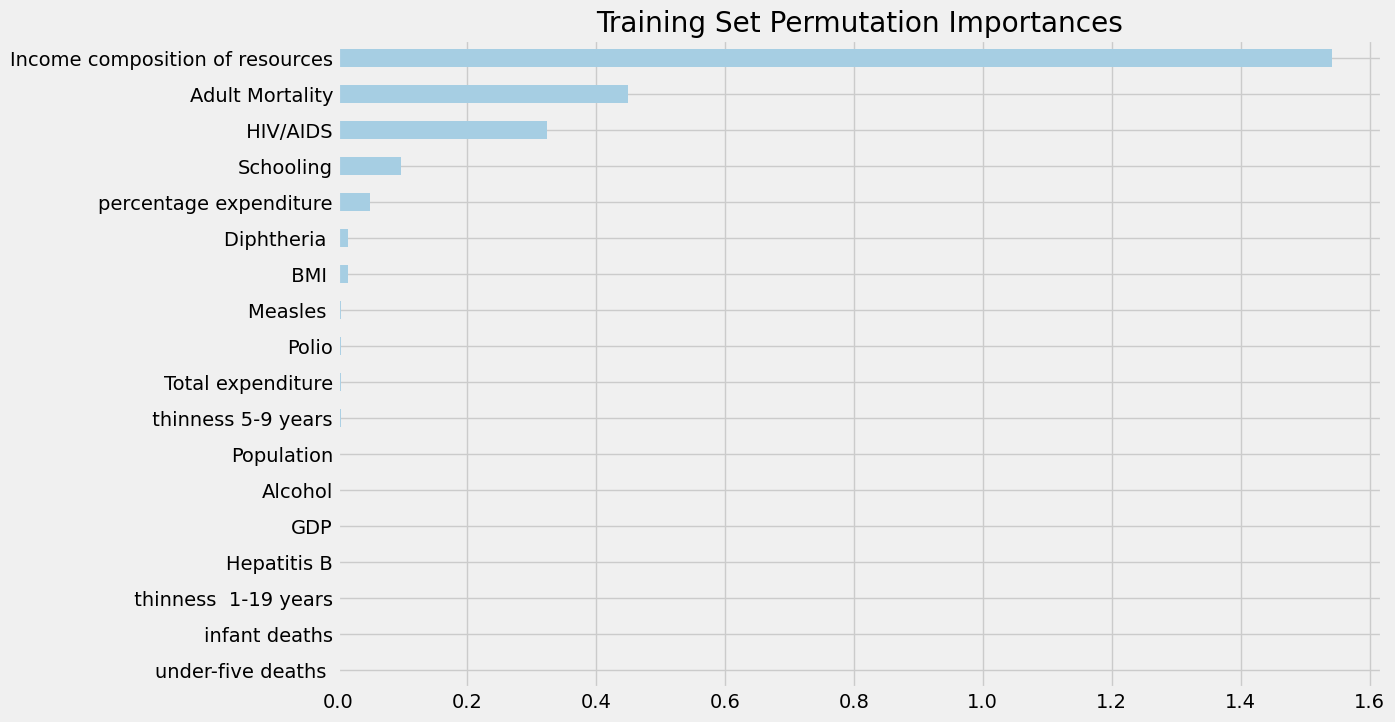

In [94]:
# printing the permutation importance
pd.Series(perm_imp_train, X.columns).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

In [95]:
# getting the shap values
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature, features=X.columns)

In [96]:
shap_slearner

{'treatment': array([[-1.30897944e-01, -1.39950367e-04,  1.15561391e-03, ...,
         -7.42627855e-03,  2.15271808e-01,  4.26074256e-02],
        [-2.77801934e-02, -5.73027238e-05,  3.28750890e-03, ...,
         -2.22273628e-03,  3.29095255e-01,  2.72186469e-02],
        [-2.28656523e-02, -1.87851945e-04,  2.18935611e-03, ...,
         -1.41594111e-04,  2.84085295e-01,  4.95009568e-02],
        ...,
        [-3.17830521e-02, -9.36553658e-05,  2.32978822e-02, ...,
         -1.94587404e-03,  3.12108903e-01,  5.47263036e-02],
        [ 2.22172220e-01,  7.71724666e-04,  2.81868946e-03, ...,
         -9.86601930e-04, -2.42832652e-01, -6.18656529e-02],
        [ 2.11383918e-01,  1.08528350e-04,  8.17646615e-04, ...,
         -4.44170455e-03, -2.01159844e-01, -3.55704601e-02]])}

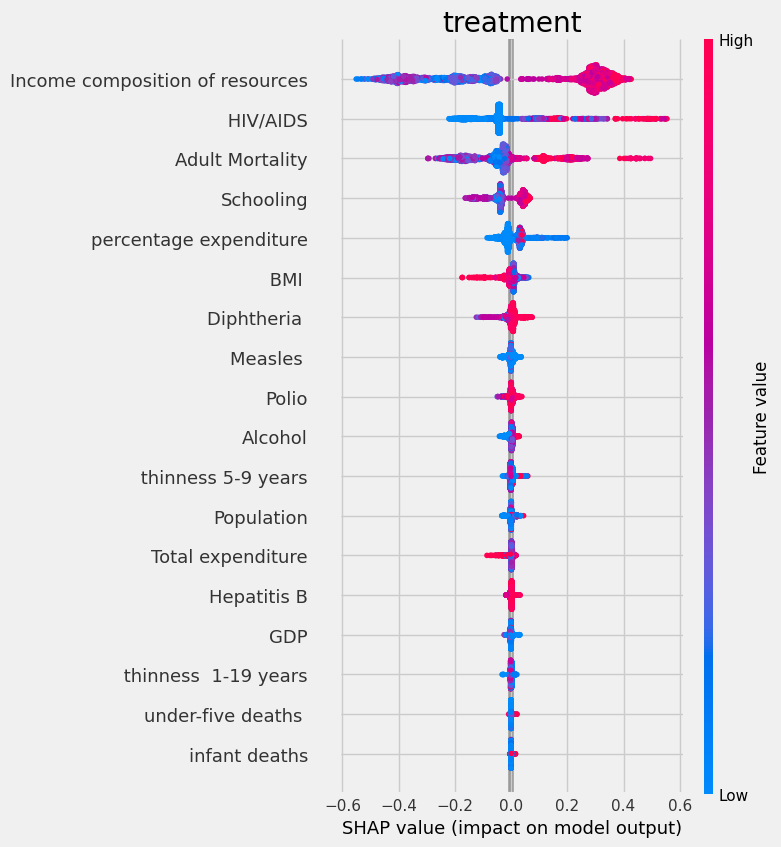

In [97]:
# plotting the beeswarm plot
slearner.plot_shap_values(X=X, shap_dict=shap_slearner,features=X.columns)